This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Load ODIM_H5 Volume data from German Weather Service

In this example, we obtain and read the last 2 hours of available volumetric radar data from German Weather Service available at [opendata.dwd.de](https://opendata.dwd.de). Finally we do some plotting.

This retrieves 24 timesteps of the 10 sweeps (moments DBZH and VRADH) of the DWD volume scan of a distinct radar. This amounts to 480 data files which are combined into one volumetric Cf/Radial2 like xarray powered structure.

Exports to single file Odim_H5 and Cf/Radial2 format are shown at the end of this tutorial.

<div class="alert alert-warning">

**Note** <br>

The following code is based on [xarray](https://docs.xarray.dev) and [xradar](https://docs.openradarscience.org/projects/xradar). It claims multiple data files and presents them in a ``DataTree``.

</div>

In [1]:
import wradlib as wrl
import warnings

warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xradar as xd

try:
    get_ipython().run_line_magic("matplotlib inline")
except:
    plt.ion()

In [2]:
import urllib3
import os
import io
import glob
import shutil
import datetime

In [3]:
from html.parser import HTMLParser


class DWDHTMLParser(HTMLParser):
    def handle_starttag(self, tag, attrs):
        if tag != "a":
            return
        self.links.append(attrs[0][1])


parser = DWDHTMLParser()

# Download data from opendata.dwd.de

In [4]:
radar = "ESS"
DBZH = "sweep_vol_z"
VRADH = "sweep_vol_v"

import certifi

opendata_url1 = f"https://opendata.dwd.de/weather/radar/sites/{DBZH}/{radar.lower()}/hdf5/filter_polarimetric/"

http = urllib3.PoolManager(cert_reqs="CERT_REQUIRED", ca_certs=certifi.where())
response = http.request("GET", opendata_url1).data.decode("utf-8")

parser.links = []
parser.feed(response)
filelist1 = parser.links[1:]

filelist1.sort(key=lambda x: x.split("-")[2])
filelist1.reverse()

opendata_url2 = f"https://opendata.dwd.de/weather/radar/sites/{VRADH}/{radar.lower()}/hdf5/filter_polarimetric/"

http = urllib3.PoolManager(cert_reqs="CERT_REQUIRED", ca_certs=certifi.where())
response = http.request("GET", opendata_url2).data.decode("utf-8")

parser.links = []
parser.feed(response)
filelist2 = parser.links[1:]

filelist2.sort(key=lambda x: x.split("-")[2])
filelist2.reverse()

## Clean up local folder

In [5]:
flist = glob.glob("ras07*")
for f in flist:
    os.remove(f)

## Download latest 24 volumes to current directory

In [6]:
for f in filelist1[: 10 * 25]:
    with http.request(
        "GET", os.path.join(opendata_url1, f), preload_content=False
    ) as r, open(f, "wb") as out:
        shutil.copyfileobj(r, out)

for f in filelist2[: 10 * 25]:
    with http.request(
        "GET", os.path.join(opendata_url2, f), preload_content=False
    ) as r, open(f, "wb") as out:
        shutil.copyfileobj(r, out)

In [7]:
volume_reflectivity = glob.glob("ras07*_dbzh_*")
volume_velocity = glob.glob("ras07*_vradh_*")

In [8]:
volume_reflectivity = np.array(
    sorted(volume_reflectivity, key=lambda x: x.split("-")[2])
)
volume_velocity = np.array(sorted(volume_velocity, key=lambda x: x.split("-")[2]))

In [9]:
volume_reflectivity = volume_reflectivity.reshape(-1, 10).T
volume_velocity = volume_velocity.reshape(-1, 10).T

## Read the data into xarray powered structure

In [10]:
dsl = []
reindex_angle = dict(
    tolerance=1.0, start_angle=0, stop_angle=360, angle_res=1.0, direction=1
)
for i, (r, v) in enumerate(zip(volume_reflectivity, volume_velocity)):
    ds0 = [
        xr.open_dataset(
            r0,
            engine="odim",
            group="sweep_0",
            reindex_angle=reindex_angle,
            fix_second_angle=True,
        )
        for r0 in r
    ]
    ds0 = [r0.assign_coords(sweep_mode=r0.sweep_mode.min()) for r0 in ds0]
    ds1 = [
        xr.open_dataset(
            v0,
            engine="odim",
            group="sweep_0",
            reindex_angle=reindex_angle,
            fix_second_angle=True,
        )
        for v0 in v
    ]
    ds1 = [r1.assign_coords(sweep_mode=r1.sweep_mode.min()) for r1 in ds1]
    ds2 = [
        xr.merge([r0, v0], compat="no_conflicts").assign(
            volume_time=r0.time.min().dt.floor("5min")
        )
        for r0, v0 in zip(ds0, ds1)
    ]
    ds2 = [r2.wrl.georef.georeference() for r2 in ds2]
    ds = xr.concat(ds2, "volume_time")
    dsl.append(ds)

In [11]:
vt_min = np.array([dsl[i].volume_time.min().values for i in range(10)])
vt_max = np.array([dsl[i].volume_time.max().values for i in range(10)])
if not all((vt_min == vt_min[0])):
    dsl = [ds.sel(volume_time=slice(vt_min.max(), vt_max.min())) for ds in dsl]
else:
    dsl = [ds.isel(volume_time=slice(1, -1)) for ds in dsl]
dsl = sorted(dsl, key=lambda ds: ds.time.min().values)

In [12]:
dtree = {"/": xd.io.backends.common._get_required_root_dataset(dsl, optional=False)}
for i, swp in enumerate(dsl):
    dsl[i]["sweep_number"] = i
dtree = xd.io.backends.common._attach_sweep_groups(dtree, dsl)

In [13]:
vol = xr.DataTree.from_dict(dtree)

In [14]:
display(vol)

<xarray.DataTree>
Group: /
│   Dimensions:              (sweep: 10, volume_time: 23)
│   Coordinates:
│     * volume_time          (volume_time) datetime64[ns] 184B 2025-01-15T09:50:0...
│   Dimensions without coordinates: sweep
│   Data variables:
│       volume_number        int64 8B 0
│       platform_type        <U5 20B 'fixed'
│       instrument_type      <U5 20B 'radar'
│       time_coverage_start  <U20 80B '2025-01-15T09:50:34Z'
│       time_coverage_end    <U20 80B '2025-01-15T11:44:02Z'
│       sweep_mode           object 8B 'azimuth_surveillance'
│       longitude            float64 8B 6.967
│       altitude             float64 8B 185.1
│       crs_wkt              int64 8B 0
│       latitude             float64 8B 51.41
│       sweep_fixed_angle    (sweep, volume_time) float64 2kB 5.499 5.499 ... 25.0
│       sweep_group_name     (sweep, volume_time) int64 2kB 0 0 0 0 0 ... 0 0 0 0 0
│   Attributes:
│       Conventions:      ODIM_H5/V2_2
│       instrument_name:  None
│       version:          None
│       title:            None
│       institution:      None
│       references:       None
│       source:           None
│       history:          None
│       comment:          im/exported using xradar
├── Group: /sweep_0
│       Dimensions:            (volume_time: 23, azimuth: 360, range: 720)
│       Coordinates: (12/15)
│         * range              (range) float32 3kB 125.0 375.0 ... 1.796e+05 1.799e+05
│         * azimuth            (azimuth) float64 3kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
│           elevation          (azimuth) float64 3kB 5.482 5.482 5.482 ... 5.482 5.482
│           time               (volume_time, azimuth) datetime64[ns] 66kB 2025-01-15T...
│           sweep_mode         object 8B 'azimuth_surveillance'
│           longitude          float64 8B 6.967
│           ...                 ...
│           y                  (azimuth, range) float64 2MB 124.4 373.3 ... 1.787e+05
│           z                  (azimuth, range) float64 2MB 197.1 220.9 ... 1.925e+04
│           gr                 (azimuth, range) float64 2MB 124.4 373.3 ... 1.787e+05
│           rays               (azimuth, range) float64 2MB 0.5 0.5 0.5 ... 359.5 359.5
│           bins               (azimuth, range) float32 1MB 125.0 375.0 ... 1.799e+05
│           crs_wkt            int64 8B 0
│       Data variables:
│           DBZH               (volume_time, azimuth, range) float64 48MB -64.0 ... -...
│           sweep_number       int64 8B 0
│           prt_mode           (volume_time) <U7 644B 'not_set' 'not_set' ... 'not_set'
│           follow_mode        (volume_time) <U7 644B 'not_set' 'not_set' ... 'not_set'
│           sweep_fixed_angle  (volume_time) float64 184B 5.499 5.499 ... 5.499 5.499
│           VRADH              (volume_time, azimuth, range) float64 48MB -128.0 ... ...
├── Group: /sweep_1
│       Dimensions:            (volume_time: 23, azimuth: 360, range: 720)
│       Coordinates: (12/15)
│         * range              (range) float32 3kB 125.0 375.0 ... 1.796e+05 1.799e+05
│         * azimuth            (azimuth) float64 3kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
│           elevation          (azimuth) float64 3kB 4.493 4.493 4.493 ... 4.493 4.493
│           time               (volume_time, azimuth) datetime64[ns] 66kB 2025-01-15T...
│           sweep_mode         object 8B 'azimuth_surveillance'
│           longitude          float64 8B 6.967
│           ...                 ...
│           y                  (azimuth, range) float64 2MB 124.6 373.8 ... 1.79e+05
│           z                  (azimuth, range) float64 2MB 194.9 214.5 ... 1.617e+04
│           gr                 (azimuth, range) float64 2MB 124.6 373.8 ... 1.79e+05
│           rays               (azimuth, range) float64 2MB 0.5 0.5 0.5 ... 359.5 359.5
│           bins               (azimuth, range) float32 1MB 125.0 375.0 ... 1.799e+05
│           crs_wkt            int64 8B 0
│       Data variables:
│           DBZH               (volume_time, azim

## Inspect structure
### Root Group

In [15]:
vol.root

<xarray.DataTree>
Group: /
│   Dimensions:              (sweep: 10, volume_time: 23)
│   Coordinates:
│     * volume_time          (volume_time) datetime64[ns] 184B 2025-01-15T09:50:0...
│   Dimensions without coordinates: sweep
│   Data variables:
│       volume_number        int64 8B 0
│       platform_type        <U5 20B 'fixed'
│       instrument_type      <U5 20B 'radar'
│       time_coverage_start  <U20 80B '2025-01-15T09:50:34Z'
│       time_coverage_end    <U20 80B '2025-01-15T11:44:02Z'
│       sweep_mode           object 8B 'azimuth_surveillance'
│       longitude            float64 8B 6.967
│       altitude             float64 8B 185.1
│       crs_wkt              int64 8B 0
│       latitude             float64 8B 51.41
│       sweep_fixed_angle    (sweep, volume_time) float64 2kB 5.499 5.499 ... 25.0
│       sweep_group_name     (sweep, volume_time) int64 2kB 0 0 0 0 0 ... 0 0 0 0 0
│   Attributes:
│       Conventions:      ODIM_H5/V2_2
│       instrument_name:  None
│       version:          None
│       title:            None
│       institution:      None
│       references:       None
│       source:           None
│       history:          None
│       comment:          im/exported using xradar
├── Group: /sweep_0
│       Dimensions:            (volume_time: 23, azimuth: 360, range: 720)
│       Coordinates: (12/15)
│         * range              (range) float32 3kB 125.0 375.0 ... 1.796e+05 1.799e+05
│         * azimuth            (azimuth) float64 3kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
│           elevation          (azimuth) float64 3kB 5.482 5.482 5.482 ... 5.482 5.482
│           time               (volume_time, azimuth) datetime64[ns] 66kB 2025-01-15T...
│           sweep_mode         object 8B 'azimuth_surveillance'
│           longitude          float64 8B 6.967
│           ...                 ...
│           y                  (azimuth, range) float64 2MB 124.4 373.3 ... 1.787e+05
│           z                  (azimuth, range) float64 2MB 197.1 220.9 ... 1.925e+04
│           gr                 (azimuth, range) float64 2MB 124.4 373.3 ... 1.787e+05
│           rays               (azimuth, range) float64 2MB 0.5 0.5 0.5 ... 359.5 359.5
│           bins               (azimuth, range) float32 1MB 125.0 375.0 ... 1.799e+05
│           crs_wkt            int64 8B 0
│       Data variables:
│           DBZH               (volume_time, azimuth, range) float64 48MB -64.0 ... -...
│           sweep_number       int64 8B 0
│           prt_mode           (volume_time) <U7 644B 'not_set' 'not_set' ... 'not_set'
│           follow_mode        (volume_time) <U7 644B 'not_set' 'not_set' ... 'not_set'
│           sweep_fixed_angle  (volume_time) float64 184B 5.499 5.499 ... 5.499 5.499
│           VRADH              (volume_time, azimuth, range) float64 48MB -128.0 ... ...
├── Group: /sweep_1
│       Dimensions:            (volume_time: 23, azimuth: 360, range: 720)
│       Coordinates: (12/15)
│         * range              (range) float32 3kB 125.0 375.0 ... 1.796e+05 1.799e+05
│         * azimuth            (azimuth) float64 3kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
│           elevation          (azimuth) float64 3kB 4.493 4.493 4.493 ... 4.493 4.493
│           time               (volume_time, azimuth) datetime64[ns] 66kB 2025-01-15T...
│           sweep_mode         object 8B 'azimuth_surveillance'
│           longitude          float64 8B 6.967
│           ...                 ...
│           y                  (azimuth, range) float64 2MB 124.6 373.8 ... 1.79e+05
│           z                  (azimuth, range) float64 2MB 194.9 214.5 ... 1.617e+04
│           gr                 (azimuth, range) float64 2MB 124.6 373.8 ... 1.79e+05
│           rays               (azimuth, range) float64 2MB 0.5 0.5 0.5 ... 359.5 359.5
│           bins               (azimuth, range) float32 1MB 125.0 375.0 ... 1.799e+05
│           crs_wkt            int64 8B 0
│       Data variables:
│           DBZH               (volume_time, azim

### Sweep Groups

In [16]:
vol["sweep_0"]

<xarray.DataTree 'sweep_0'>
Group: /sweep_0
    Dimensions:            (sweep: 10, volume_time: 23, azimuth: 360, range: 720)
    Coordinates: (12/15)
      * range              (range) float32 3kB 125.0 375.0 ... 1.796e+05 1.799e+05
      * azimuth            (azimuth) float64 3kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
        elevation          (azimuth) float64 3kB 5.482 5.482 5.482 ... 5.482 5.482
        time               (volume_time, azimuth) datetime64[ns] 66kB 2025-01-15T...
        sweep_mode         object 8B 'azimuth_surveillance'
        longitude          float64 8B 6.967
        ...                 ...
        y                  (azimuth, range) float64 2MB 124.4 373.3 ... 1.787e+05
        z                  (azimuth, range) float64 2MB 197.1 220.9 ... 1.925e+04
        gr                 (azimuth, range) float64 2MB 124.4 373.3 ... 1.787e+05
        rays               (azimuth, range) float64 2MB 0.5 0.5 0.5 ... 359.5 359.5
        bins               (azimuth, range) float32 1MB 125.0 375.0 ... 1.799e+05
        crs_wkt            int64 8B 0
    Inherited coordinates:
      * volume_time        (volume_time) datetime64[ns] 184B 2025-01-15T09:50:00 ...
    Dimensions without coordinates: sweep
    Data variables:
        DBZH               (volume_time, azimuth, range) float64 48MB -64.0 ... -...
        sweep_number       int64 8B 0
        prt_mode           (volume_time) <U7 644B 'not_set' 'not_set' ... 'not_set'
        follow_mode        (volume_time) <U7 644B 'not_set' 'not_set' ... 'not_set'
        sweep_fixed_angle  (volume_time) float64 184B 5.499 5.499 ... 5.499 5.499
        VRADH              (volume_time, azimuth, range) float64 48MB -128.0 ... ...

## plot sweeps
### DBZH

In [17]:
vol["sweep_0"].isel(volume_time=0)

<xarray.DataTree 'sweep_0'>
Group: /
    Dimensions:            (azimuth: 360, range: 720)
    Coordinates: (12/16)
        volume_time        datetime64[ns] 8B 2025-01-15T09:50:00
      * range              (range) float32 3kB 125.0 375.0 ... 1.796e+05 1.799e+05
      * azimuth            (azimuth) float64 3kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
        elevation          (azimuth) float64 3kB 5.482 5.482 5.482 ... 5.482 5.482
        time               (azimuth) datetime64[ns] 3kB 2025-01-15T09:50:54.04549...
        sweep_mode         object 8B 'azimuth_surveillance'
        ...                 ...
        y                  (azimuth, range) float64 2MB 124.4 373.3 ... 1.787e+05
        z                  (azimuth, range) float64 2MB 197.1 220.9 ... 1.925e+04
        gr                 (azimuth, range) float64 2MB 124.4 373.3 ... 1.787e+05
        rays               (azimuth, range) float64 2MB 0.5 0.5 0.5 ... 359.5 359.5
        bins               (azimuth, range) float32 1MB 125.0 375.0 ... 1.799e+05
        crs_wkt            int64 8B 0
    Data variables:
        DBZH               (azimuth, range) float64 2MB -64.0 -64.0 ... -64.0 -64.0
        sweep_number       int64 8B 0
        prt_mode           <U7 28B 'not_set'
        follow_mode        <U7 28B 'not_set'
        sweep_fixed_angle  float64 8B 5.499
        VRADH              (azimuth, range) float64 2MB -128.0 -128.0 ... -128.0

In [18]:
vol.match("sweep*")

<xarray.DataTree>
Group: /
├── Group: /sweep_0
│       Dimensions:            (volume_time: 23, azimuth: 360, range: 720)
│       Coordinates: (12/16)
│         * volume_time        (volume_time) datetime64[ns] 184B 2025-01-15T09:50:00 ...
│         * range              (range) float32 3kB 125.0 375.0 ... 1.796e+05 1.799e+05
│         * azimuth            (azimuth) float64 3kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
│           elevation          (azimuth) float64 3kB 5.482 5.482 5.482 ... 5.482 5.482
│           time               (volume_time, azimuth) datetime64[ns] 66kB 2025-01-15T...
│           sweep_mode         object 8B 'azimuth_surveillance'
│           ...                 ...
│           y                  (azimuth, range) float64 2MB 124.4 373.3 ... 1.787e+05
│           z                  (azimuth, range) float64 2MB 197.1 220.9 ... 1.925e+04
│           gr                 (azimuth, range) float64 2MB 124.4 373.3 ... 1.787e+05
│           rays               (azimuth, range) float64 2MB 0.5 0.5 0.5 ... 359.5 359.5
│           bins               (azimuth, range) float32 1MB 125.0 375.0 ... 1.799e+05
│           crs_wkt            int64 8B 0
│       Data variables:
│           DBZH               (volume_time, azimuth, range) float64 48MB -64.0 ... -...
│           sweep_number       int64 8B 0
│           prt_mode           (volume_time) <U7 644B 'not_set' 'not_set' ... 'not_set'
│           follow_mode        (volume_time) <U7 644B 'not_set' 'not_set' ... 'not_set'
│           sweep_fixed_angle  (volume_time) float64 184B 5.499 5.499 ... 5.499 5.499
│           VRADH              (volume_time, azimuth, range) float64 48MB -128.0 ... ...
├── Group: /sweep_1
│       Dimensions:            (volume_time: 23, azimuth: 360, range: 720)
│       Coordinates: (12/16)
│         * volume_time        (volume_time) datetime64[ns] 184B 2025-01-15T09:50:00 ...
│         * range              (range) float32 3kB 125.0 375.0 ... 1.796e+05 1.799e+05
│         * azimuth            (azimuth) float64 3kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
│           elevation          (azimuth) float64 3kB 4.493 4.493 4.493 ... 4.493 4.493
│           time               (volume_time, azimuth) datetime64[ns] 66kB 2025-01-15T...
│           sweep_mode         object 8B 'azimuth_surveillance'
│           ...                 ...
│           y                  (azimuth, range) float64 2MB 124.6 373.8 ... 1.79e+05
│           z                  (azimuth, range) float64 2MB 194.9 214.5 ... 1.617e+04
│           gr                 (azimuth, range) float64 2MB 124.6 373.8 ... 1.79e+05
│           rays               (azimuth, range) float64 2MB 0.5 0.5 0.5 ... 359.5 359.5
│           bins               (azimuth, range) float32 1MB 125.0 375.0 ... 1.799e+05
│           crs_wkt            int64 8B 0
│       Data variables:
│           DBZH               (volume_time, azimuth, range) float64 48MB -64.0 ... -...
│           sweep_number       int64 8B 1
│           prt_mode           (volume_time) <U7 644B 'not_set' 'not_set' ... 'not_set'
│           follow_mode        (volume_time) <U7 644B 'not_set' 'not_set' ... 'not_set'
│           sweep_fixed_angle  (volume_time) float64 184B 4.499 4.499 ... 4.499 4.499
│           VRADH              (volume_time, azimuth, range) float64 48MB -128.0 ... ...
├── Group: /sweep_2
│       Dimensions:            (volume_time: 23, azimuth: 360, range: 720)
│       Coordinates: (12/16)
│         * volume_time        (volume_time) datetime64[ns] 184B 2025-01-15T09:50:00 ...
│         * range              (range) float32 3kB 125.0 375.0 ... 1.796e+05 1.799e+05
│         * azimuth            (azimuth) float64 3kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
│           elevation          (azimuth) float64 3kB 3.494 3.494 3.494 ... 3.494 3.494
│           time               (volume_time, azimuth) datetime64[ns] 66kB 2025-01-15T...
│           sweep_mode         object 8B 'azimuth_surveillance'
│           ...                 ...
│           y             

In [19]:
swp = vol["sweep_0"].isel(volume_time=0).ds
swp.sweep_fixed_angle.values

array(5.49865723)

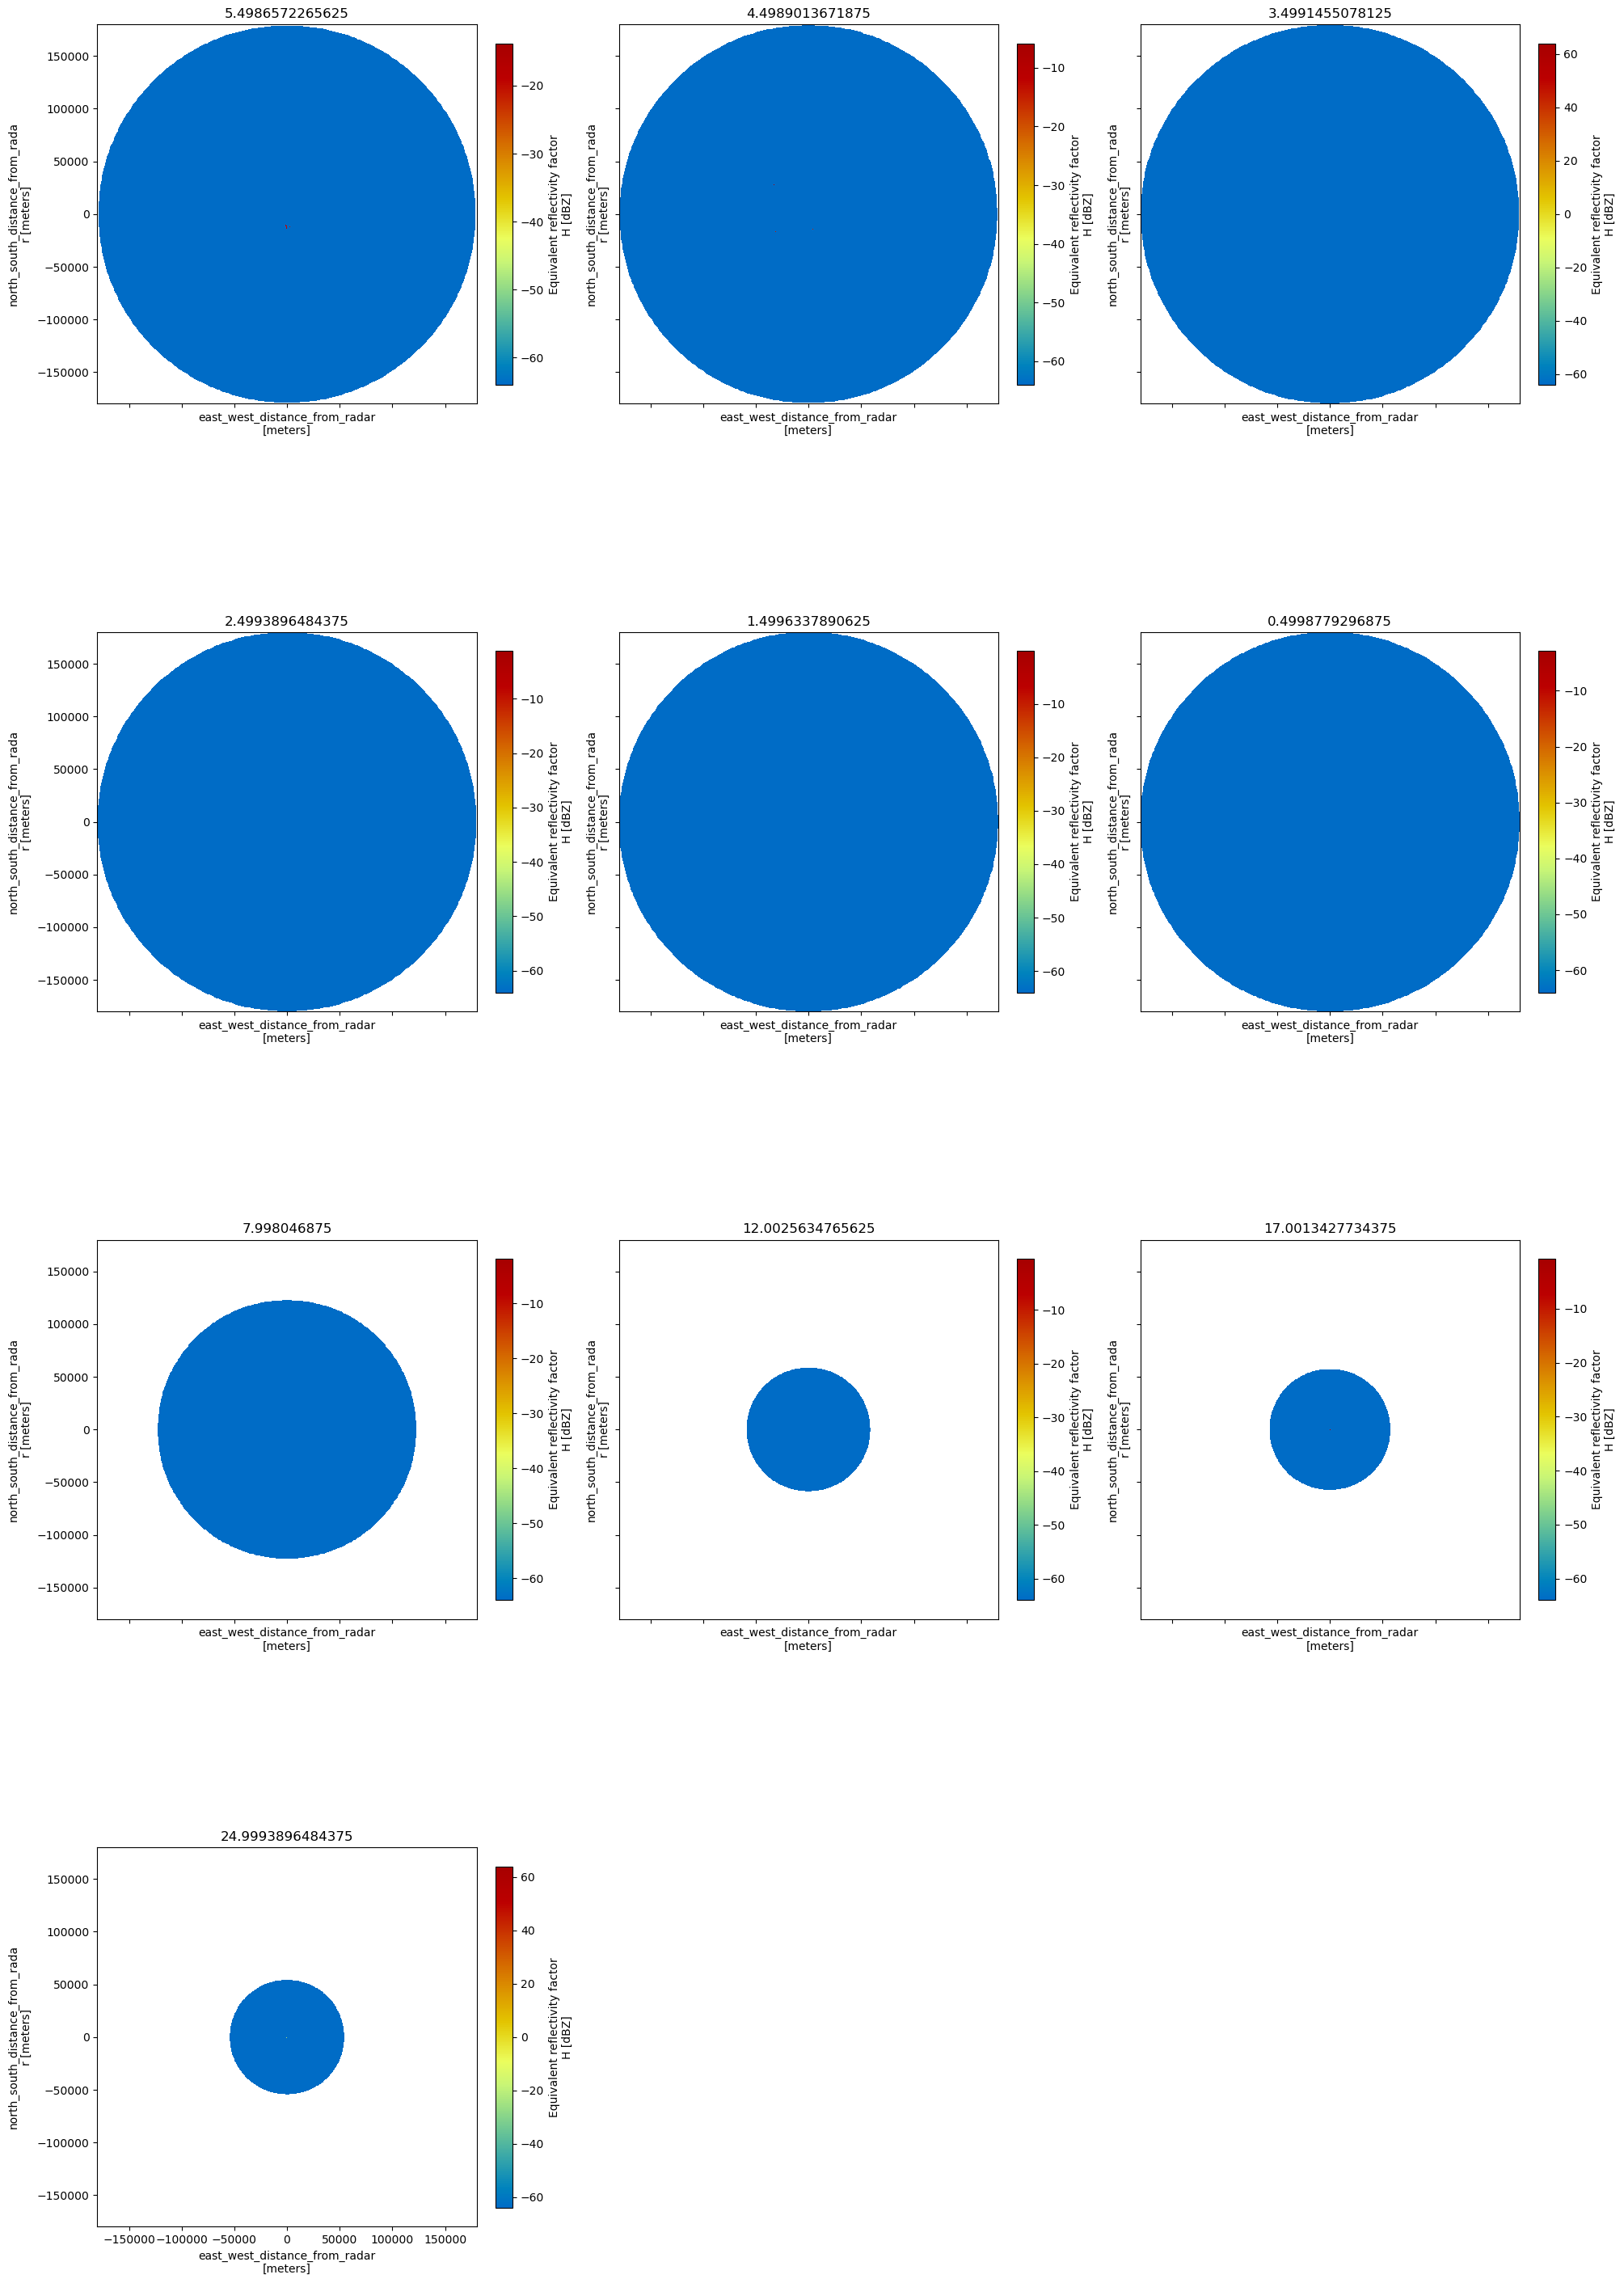

In [20]:
fig, gs = plt.subplots(
    4, 3, figsize=(20, 30), sharex=True, sharey=True, constrained_layout=True
)

for i, grp in enumerate(vol.match("sweep_*")):
    ax = gs.flat[i]
    swp = vol[grp].isel(volume_time=0).ds
    swp.DBZH.wrl.vis.plot(ax=ax, fig=fig)
    ax.set_title(swp.sweep_fixed_angle.values)

fig.delaxes(gs.flat[-2])
fig.delaxes(gs.flat[-1])

### VRADH

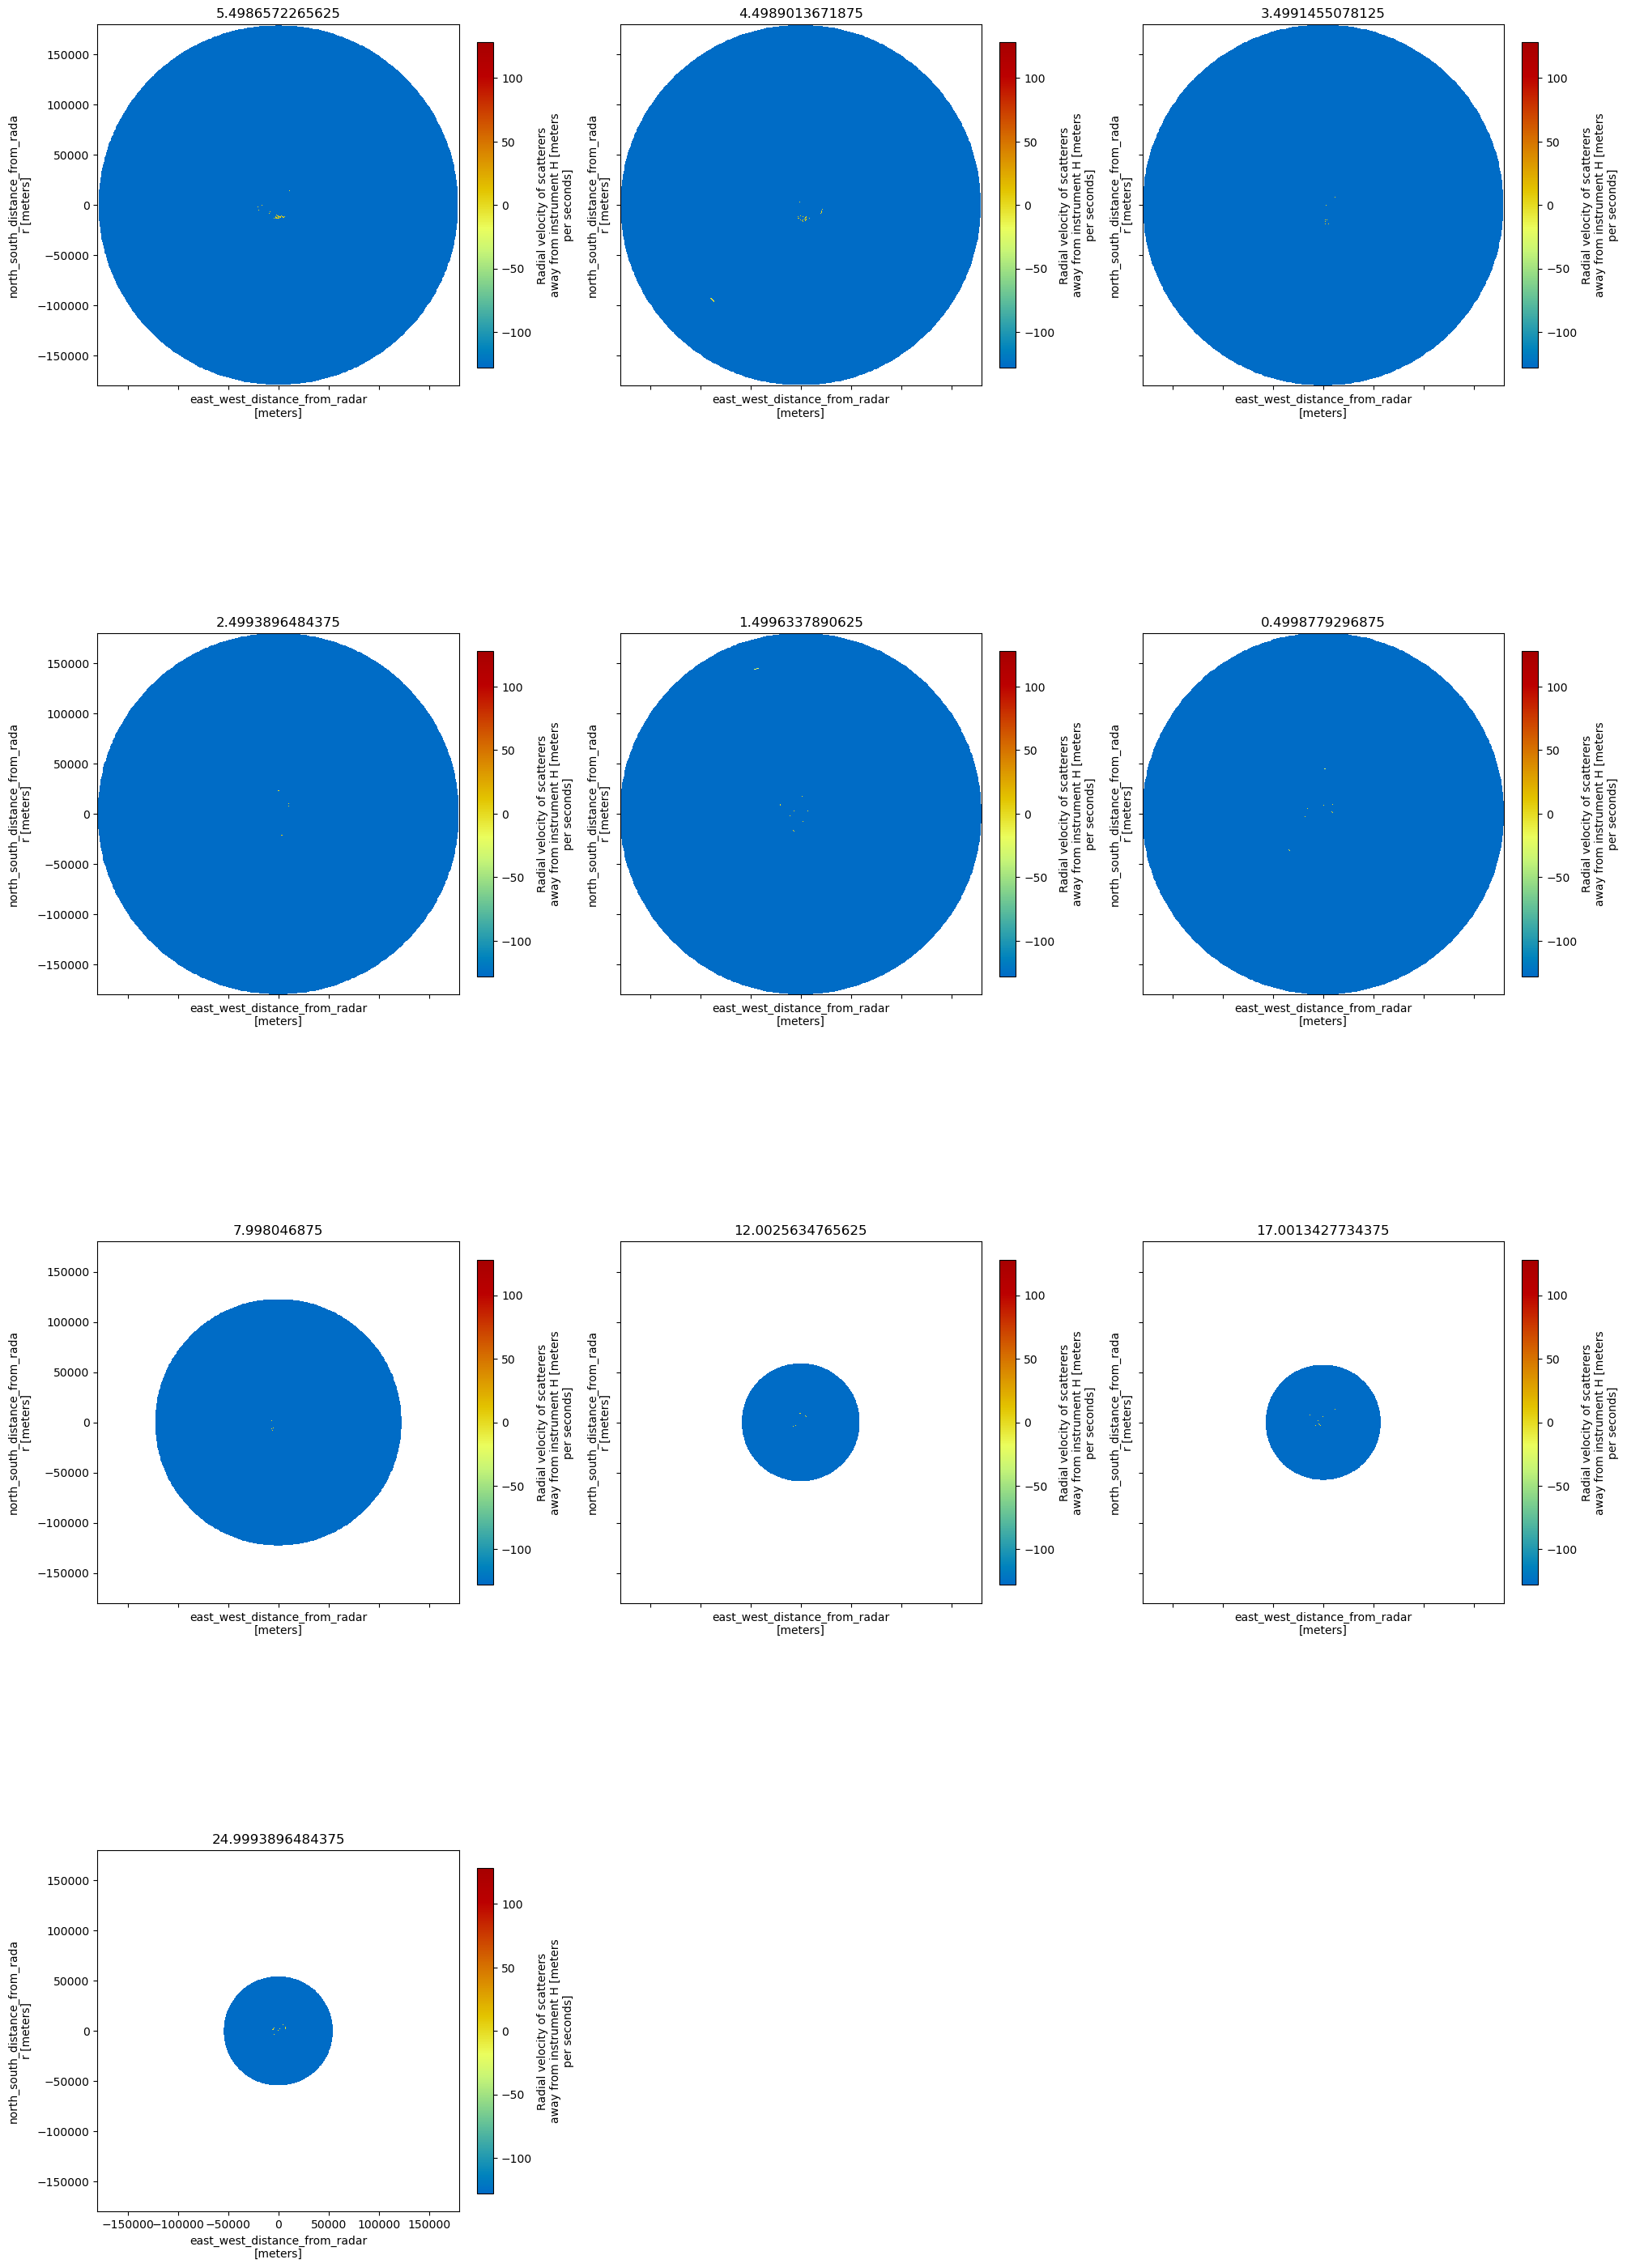

In [21]:
fig, gs = plt.subplots(
    4, 3, figsize=(20, 30), sharex=True, sharey=True, constrained_layout=True
)

for i, grp in enumerate(vol.match("sweep_*")):
    ax = gs.flat[i]
    swp = vol[grp].isel(volume_time=0).ds
    swp.VRADH.wrl.vis.plot(ax=ax, fig=fig)
    ax.set_title(swp.sweep_fixed_angle.values)

fig.delaxes(gs.flat[-2])
fig.delaxes(gs.flat[-1])

### Plot single sweep using cartopy

In [22]:
vol0 = vol.isel(volume_time=0)
swp = vol0["sweep_9"].ds

In [23]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

map_trans = ccrs.AzimuthalEquidistant(
    central_latitude=swp.latitude.values,
    central_longitude=swp.longitude.values,
)

< GeoAxes: +proj=aeqd +ellps=WGS84 +lon_0=6.967111 +lat_0=51.405649 +x_0=0.0 +y_0=0.0 +no_defs +type=crs >


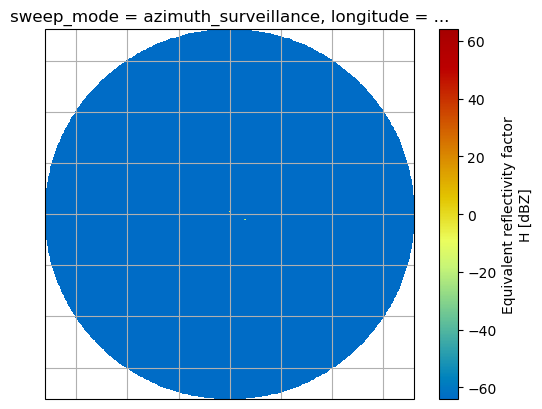

In [24]:
map_proj = ccrs.AzimuthalEquidistant(
    central_latitude=swp.latitude.values,
    central_longitude=swp.longitude.values,
)

pm = swp.DBZH.wrl.georef.georeference().wrl.vis.plot(crs=map_proj)
ax = plt.gca()
ax.gridlines(crs=map_proj)
print(ax)

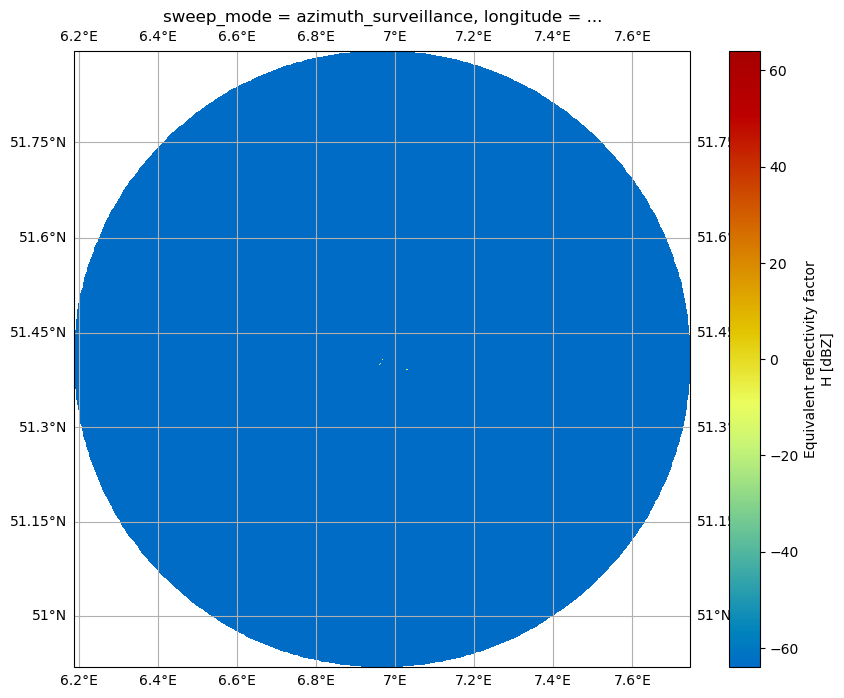

In [25]:
map_proj = ccrs.Mercator(central_longitude=swp.longitude.values)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=map_proj)
pm = swp.DBZH.wrl.georef.georeference().wrl.vis.plot(ax=ax)
ax.gridlines(draw_labels=True)

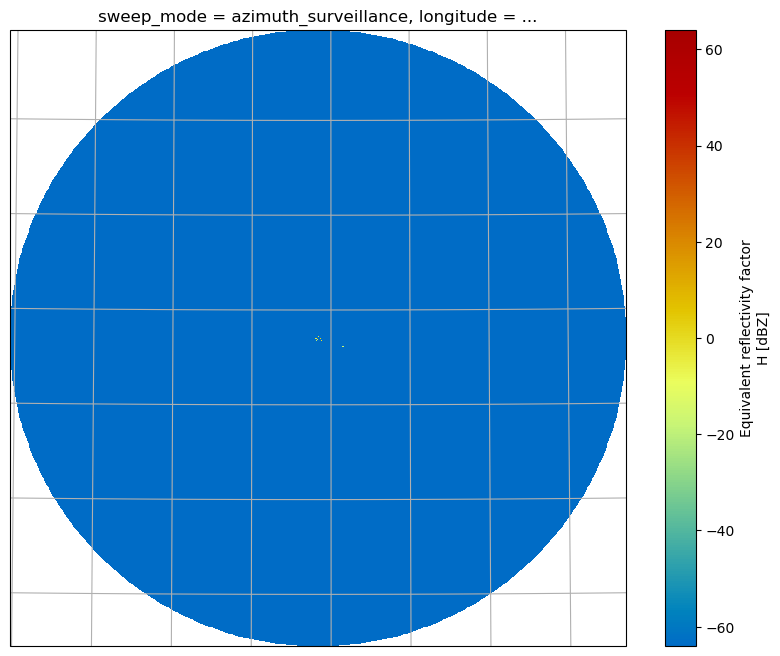

In [26]:
fig = plt.figure(figsize=(10, 8))
proj = ccrs.AzimuthalEquidistant(
    central_latitude=swp.latitude.values,
    central_longitude=swp.longitude.values,
)
ax = fig.add_subplot(111, projection=proj)
pm = swp.DBZH.wrl.georef.georeference().wrl.vis.plot(ax=ax)
ax.gridlines()

### Inspect radar moments

The DataArrays can be accessed by key or by attribute. Each DataArray inherits dimensions and coordinates of it's parent dataset. There are attributes connected which are defined by Cf/Radial and/or ODIM_H5 standard.

In [27]:
vol["sweep_9"].isel(volume_time=0).ds.DBZH

<xarray.DataArray 'DBZH' (azimuth: 360, range: 240)> Size: 691kB
array([[-64.00292982, -64.00292982, -64.00292982, ..., -64.00292982,
        -64.00292982, -64.00292982],
       [-64.00292982, -64.00292982, -64.00292982, ..., -64.00292982,
        -64.00292982, -64.00292982],
       [-64.00292982, -64.00292982, -64.00292982, ..., -64.00292982,
        -64.00292982, -64.00292982],
       ...,
       [ -3.28530664,  -3.35855218, -12.57870081, ..., -64.00292982,
        -64.00292982, -64.00292982],
       [-64.00292982,  -2.277448  , -64.00292982, ..., -64.00292982,
        -64.00292982, -64.00292982],
       [-64.00292982, -64.00292982, -64.00292982, ..., -64.00292982,
        -64.00292982, -64.00292982]])
Coordinates: (12/16)
    volume_time  datetime64[ns] 8B 2025-01-15T09:50:00
  * range        (range) float32 960B 125.0 375.0 625.0 ... 5.962e+04 5.988e+04
  * azimuth      (azimuth) float64 3kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
    elevation    (azimuth) float64 3kB 24.98 24.98 24.98 ... 24.98 24.98 24.98
    time         (azimuth) datetime64[ns] 3kB 2025-01-15T09:53:54.068000 ... ...
    sweep_mode   object 8B 'azimuth_surveillance'
    ...           ...
    y            (azimuth, range) float64 691kB 113.3 339.9 ... 5.411e+04
    z            (azimuth, range) float64 691kB 237.9 343.5 ... 2.565e+04
    gr           (azimuth, range) float64 691kB 113.3 339.9 ... 5.411e+04
    rays         (azimuth, range) float64 691kB 0.5 0.5 0.5 ... 359.5 359.5
    bins         (azimuth, range) float32 346kB 125.0 375.0 ... 5.988e+04
    crs_wkt      int64 8B 0
Attributes:
    _Undetect:      0.0
    long_name:      Equivalent reflectivity factor H
    units:          dBZ
    standard_name:  radar_equivalent_reflectivity_factor_h

In [28]:
vol["sweep_9"].isel(volume_time=0).ds.sweep_mode

<xarray.DataArray 'sweep_mode' ()> Size: 8B
array('azimuth_surveillance', dtype=object)
Coordinates:
    volume_time  datetime64[ns] 8B 2025-01-15T09:50:00
    sweep_mode   object 8B 'azimuth_surveillance'
    longitude    float64 8B 6.967
    latitude     float64 8B 51.41
    altitude     float64 8B 185.1
    crs_wkt      int64 8B 0

## Plot Quasi Vertical Profile

In [29]:
ts = vol["sweep_9"]
ts

<xarray.DataTree 'sweep_9'>
Group: /sweep_9
    Dimensions:            (sweep: 10, volume_time: 23, azimuth: 360, range: 240)
    Coordinates: (12/15)
      * range              (range) float32 960B 125.0 375.0 ... 5.962e+04 5.988e+04
      * azimuth            (azimuth) float64 3kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
        elevation          (volume_time, azimuth) float64 66kB 24.98 24.98 ... 24.98
        time               (volume_time, azimuth) datetime64[ns] 66kB 2025-01-15T...
        sweep_mode         object 8B 'azimuth_surveillance'
        longitude          float64 8B 6.967
        ...                 ...
        y                  (volume_time, azimuth, range) float64 16MB 113.3 ... 5...
        z                  (volume_time, azimuth, range) float64 16MB 237.9 ... 2...
        gr                 (volume_time, azimuth, range) float64 16MB 113.3 ... 5...
        rays               (azimuth, range) float64 691kB 0.5 0.5 ... 359.5 359.5
        bins               (azimuth, range) float32 346kB 125.0 375.0 ... 5.988e+04
        crs_wkt            int64 8B 0
    Inherited coordinates:
      * volume_time        (volume_time) datetime64[ns] 184B 2025-01-15T09:50:00 ...
    Dimensions without coordinates: sweep
    Data variables:
        DBZH               (volume_time, azimuth, range) float64 16MB -64.0 ... -...
        sweep_number       int64 8B 9
        prt_mode           (volume_time) <U7 644B 'not_set' 'not_set' ... 'not_set'
        follow_mode        (volume_time) <U7 644B 'not_set' 'not_set' ... 'not_set'
        sweep_fixed_angle  (volume_time) float64 184B 25.0 25.0 25.0 ... 25.0 25.0
        VRADH              (volume_time, azimuth, range) float64 16MB -128.0 ... ...

(0.0, 20000.0)

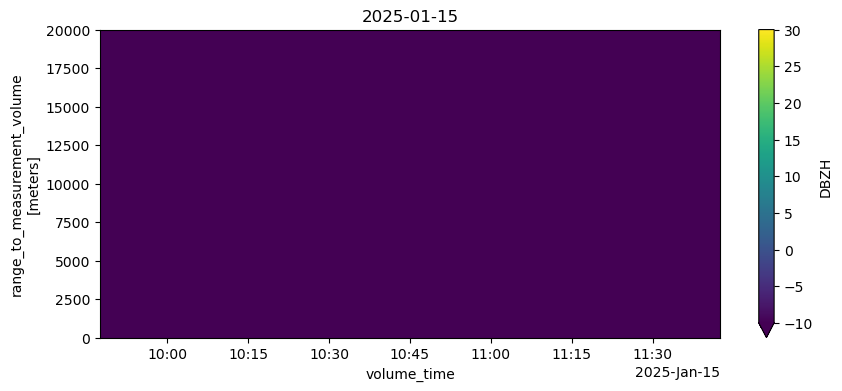

In [30]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
ts.ds.DBZH.median("azimuth").plot(x="volume_time", vmin=-10, vmax=30, ax=ax)
ax.set_title(f"{np.datetime_as_string(ts.ds.time[0][0].values, unit='D')}")
ax.set_ylim(0, 20000)

## Export to OdimH5

This exports the radar volume at given timestep including all moments into one ODIM_H5 compliant data file.

In [31]:
xd.io.to_odim(vol0, "dwd_odim.h5", source="RAD:DWD")

## Export to Cf/Radial2

This exports the radar volume at given timestep including all moments into one Cf/Radial2 compliant data file.

In [32]:
xd.io.to_cfradial2(vol0, "dwd_cfradial2.nc")

## Import again


In [33]:
vol1 = xd.io.open_odim_datatree("dwd_odim.h5")
display(vol1)

<xarray.DataTree>
Group: /
│   Dimensions:              (sweep: 10)
│   Dimensions without coordinates: sweep
│   Data variables:
│       volume_number        int64 8B 0
│       platform_type        <U5 20B 'fixed'
│       instrument_type      <U5 20B 'radar'
│       time_coverage_start  <U20 80B '2025-01-15T09:50:35Z'
│       time_coverage_end    <U20 80B '2025-01-15T09:54:01Z'
│       longitude            float64 8B 6.967
│       altitude             float64 8B 185.1
│       latitude             float64 8B 51.41
│       sweep_fixed_angle    (sweep) float64 80B 5.499 4.499 3.499 ... 17.0 25.0
│       sweep_group_name     (sweep) int64 80B 0 1 2 3 4 5 6 7 8 9
│   Attributes:
│       Conventions:      ODIM_H5/V2_2
│       instrument_name:  None
│       version:          None
│       title:            None
│       institution:      None
│       references:       None
│       source:           None
│       history:          None
│       comment:          im/exported using xradar
├── Group: /sweep_0
│       Dimensions:            (azimuth: 360, range: 720)
│       Coordinates:
│           elevation          (azimuth) float64 3kB ...
│           time               (azimuth) datetime64[ns] 3kB 2025-01-15T09:50:53.97503...
│         * range              (range) float32 3kB 125.0 375.0 ... 1.796e+05 1.799e+05
│           longitude          float64 8B ...
│           latitude           float64 8B ...
│           altitude           float64 8B ...
│         * azimuth            (azimuth) float32 1kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
│       Data variables:
│           DBZH               (azimuth, range) float64 2MB ...
│           VRADH              (azimuth, range) float64 2MB ...
│           sweep_mode         <U20 80B ...
│           sweep_number       int64 8B ...
│           prt_mode           <U7 28B ...
│           follow_mode        <U7 28B ...
│           sweep_fixed_angle  float64 8B ...
├── Group: /sweep_1
│       Dimensions:            (azimuth: 360, range: 720)
│       Coordinates:
│           elevation          (azimuth) float64 3kB ...
│           time               (azimuth) datetime64[ns] 3kB 2025-01-15T09:51:16.42503...
│         * range              (range) float32 3kB 125.0 375.0 ... 1.796e+05 1.799e+05
│           longitude          float64 8B ...
│           latitude           float64 8B ...
│           altitude           float64 8B ...
│         * azimuth            (azimuth) float32 1kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
│       Data variables:
│           DBZH               (azimuth, range) float64 2MB ...
│           VRADH              (azimuth, range) float64 2MB ...
│           sweep_mode         <U20 80B ...
│           sweep_number       int64 8B ...
│           prt_mode           <U7 28B ...
│           follow_mode        <U7 28B ...
│           sweep_fixed_angle  float64 8B ...
├── Group: /sweep_2
│       Dimensions:            (azimuth: 360, range: 720)
│       Coordinates:
│           elevation          (azimuth) float64 3kB ...
│           time               (azimuth) datetime64[ns] 3kB 2025-01-15T09:51:38.81391...
│         * range              (range) float32 3kB 125.0 375.0 ... 1.796e+05 1.799e+05
│           longitude          float64 8B ...
│           latitude           float64 8B ...
│           altitude           float64 8B ...
│         * azimuth            (azimuth) float32 1kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
│       Data variables:
│           DBZH               (azimuth, range) float64 2MB ...
│           VRADH              (azimuth, range) float64 2MB ...
│           sweep_mode         <U20 80B ...
│           sweep_number       int64 8B ...
│           prt_mode           <U7 28B ...
│           follow_mode        <U7 28B ...
│           sweep_fixed_angle  float64 8B ...
├── Group: /sweep_3
│       Dimensions:            (azimuth: 360, range: 720)
│       Coordinates:
│           elevation          (azimuth) float64 3kB ...
│           time               (azimuth) datetime64[ns] 3kB 2025-0

In [34]:
vol2 = xr.open_datatree("dwd_cfradial2.nc")
display(vol2)

<xarray.DataTree>
Group: /
│   Dimensions:              (sweep: 10)
│   Coordinates:
│       volume_time          datetime64[ns] 8B ...
│   Dimensions without coordinates: sweep
│   Data variables:
│       volume_number        int64 8B ...
│       platform_type        <U5 20B ...
│       instrument_type      <U5 20B ...
│       time_coverage_start  <U20 80B ...
│       time_coverage_end    <U20 80B ...
│       sweep_mode           <U20 80B ...
│       longitude            float64 8B ...
│       altitude             float64 8B ...
│       crs_wkt              int64 8B ...
│       latitude             float64 8B ...
│       sweep_fixed_angle    (sweep) float64 80B ...
│       sweep_group_name     (sweep) int64 80B ...
│   Attributes:
│       Conventions:      ODIM_H5/V2_2
│       instrument_name:  None
│       version:          None
│       title:            None
│       institution:      None
│       references:       None
│       source:           None
│       history:          None
│       comment:          im/exported using xradar
├── Group: /sweep_0
│       Dimensions:            (time: 360, range: 720)
│       Coordinates:
│         * range              (range) float32 3kB 125.0 375.0 ... 1.796e+05 1.799e+05
│           azimuth            (time) float64 3kB ...
│           elevation          (time) float64 3kB ...
│         * time               (time) datetime64[ns] 3kB 2025-01-15T09:50:34.668000 ....
│           sweep_mode         <U20 80B ...
│       Data variables:
│           DBZH               (time, range) float64 2MB ...
│           sweep_number       int64 8B ...
│           prt_mode           <U7 28B ...
│           follow_mode        <U7 28B ...
│           sweep_fixed_angle  float64 8B ...
│           VRADH              (time, range) float64 2MB ...
├── Group: /sweep_1
│       Dimensions:            (time: 360, range: 720)
│       Coordinates:
│         * range              (range) float32 3kB 125.0 375.0 ... 1.796e+05 1.799e+05
│           azimuth            (time) float64 3kB ...
│           elevation          (time) float64 3kB ...
│         * time               (time) datetime64[ns] 3kB 2025-01-15T09:50:57.73299968...
│           sweep_mode         <U20 80B ...
│       Data variables:
│           DBZH               (time, range) float64 2MB ...
│           sweep_number       int64 8B ...
│           prt_mode           <U7 28B ...
│           follow_mode        <U7 28B ...
│           sweep_fixed_angle  float64 8B ...
│           VRADH              (time, range) float64 2MB ...
├── Group: /sweep_2
│       Dimensions:            (time: 360, range: 720)
│       Coordinates:
│         * range              (range) float32 3kB 125.0 375.0 ... 1.796e+05 1.799e+05
│           azimuth            (time) float64 3kB ...
│           elevation          (time) float64 3kB ...
│         * time               (time) datetime64[ns] 3kB 2025-01-15T09:51:20.86000025...
│           sweep_mode         <U20 80B ...
│       Data variables:
│           DBZH               (time, range) float64 2MB ...
│           sweep_number       int64 8B ...
│           prt_mode           <U7 28B ...
│           follow_mode        <U7 28B ...
│           sweep_fixed_angle  float64 8B ...
│           VRADH              (time, range) float64 2MB ...
├── Group: /sweep_3
│       Dimensions:            (time: 360, range: 720)
│       Coordinates:
│         * range              (range) float32 3kB 125.0 375.0 ... 1.796e+05 1.799e+05
│           azimuth            (time) float64 3kB ...
│           elevation          (time) float64 3kB ...
│         * time               (time) datetime64[ns] 3kB 2025-01-15T09:51:43.98600012...
│           sweep_mode         <U20 80B ...
│       Data variables:
│           DBZH               (time, range) float64 2MB ...
│           sweep_number       int64 8B ...
│           prt_mode           <U7 28B ...
│           follow_mode        <U7 28B ...
│           sweep_fixed_angle  float64 8B ...
│           VRADH           